In [1]:
!pip install scikit-learn Flask librosa opendatasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/adarshsingh0903/audio-deepfake-detection-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abhishekkamble12
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/adarshsingh0903/audio-deepfake-detection-dataset


100%|██████████| 1.09G/1.09G [00:12<00:00, 92.2MB/s]


In [4]:
# loading the dataset
import os
import librosa
import numpy as np
from tqdm import tqdm

def extract_features(file_path):
    # Load audio (resample to 16kHz is standard for deepfake detection)
    audio, sr = librosa.load(file_path, sr=16000)
    # sr -> sample rate

    # Extract MFCCs (Commonly used for deepfake detection)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)

    # Take the mean across time to get a fixed-size vector
    return np.mean(mfccs.T, axis=0)

# Paths from your image
dataset_root = "audio-deepfake-detection-dataset"
real_folder = os.path.join(dataset_root, "real_samples")

X, y = [], []

# 1. Load Real Samples (Label 0)
print("Loading real samples...")
for file in os.listdir(real_folder):
    if file.endswith(('.wav', '.mp3')):
        path = os.path.join(real_folder, file)
        X.append(extract_features(path))
        y.append(0)

# 2. Load Fake Samples from all other subfolders (Label 1)
print("Loading fake samples...")
# List of subfolders from your image to treat as 'Fake'
fake_subfolders = ['FlashSpeech', 'NaturalSpeech3', 'OpenAI', 'PromptTTS2', 'VALLE', 'VoiceBox', 'seedtts_files', 'xTTS']

for sub in fake_subfolders:
    sub_path = os.path.join(dataset_root, sub)
    if os.path.isdir(sub_path):
        for file in tqdm(os.listdir(sub_path), desc=f"Processing {sub}"):
            if file.endswith(('.wav', '.mp3')):
                path = os.path.join(sub_path, file)
                try:
                    X.append(extract_features(path))
                    y.append(1)
                except Exception as e:
                    print(f"Error loading {path}: {e}")

X = np.array(X)
y = np.array(y)


Loading real samples...
Loading fake samples...


Processing xTTS: 100%|██████████| 600/600 [00:09<00:00, 60.59it/s]


X holds the feature and y hols the label

In [9]:
X.shape

(4447, 40)

In [8]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [10]:
# augmenting ==> making new cobination of the data  by applying the filter

In [12]:
# creating the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input

def create_model(input_shape):
    model = Sequential()

    # 1. Use Input layer to define the starting shape
    model.add(Input(shape=input_shape))

    # 2. First LSTM Layer (Must return sequences to feed into the next LSTM)
    # Note: Using LSTM first is better for time-series audio data than starting with Dense
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))

    # 3. Second LSTM Layer (return_sequences=False because the next layer is Dense)
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))

    # 4. Dense (Fully Connected) Layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    # 5. Output Layer
    # Use 'sigmoid' for binary classification (Real vs Fake)
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Example: If using 40 MFCC features over time
# input_shape = (timesteps, 40)
# my_model = create_model((100, 40))
# my_model.summary()

In [19]:
def train_and_test(model, X_train, y_train, X_test, y_test,epochs=50,batch_size=32):
  history=model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test_reshaped,y_test),verbose=1)
  test_loss,test_acc=model.evaluate(X_test_reshaped,y_test)
  print("Test Accuracy:",test_acc)
  return history

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss over epochs.
    """
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, labels=['Real', 'Fake']):
    """
    Plots the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [14]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM (samples, timesteps, features)
# Since we took the mean of MFCCs, each sample is a 1D vector of 40 features.
# LSTM expects a 3D input, so we'll treat each sample as a single timestep.
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

print("X_train_reshaped shape:", X_train_reshaped.shape)
print("X_test_reshaped shape:", X_test_reshaped.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train_reshaped shape: (3557, 1, 40)
X_test_reshaped shape: (890, 1, 40)
y_train shape: (3557,)
y_test shape: (890,)


In [15]:
# Create the model
input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
model = create_model(input_shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,833 (597.00 KB)

 Trainable params: 152,833 (597.00 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Train the model
history = train_and_test(model, X_train_reshaped, y_train, X_test_reshaped, y_test, epochs=100, batch_size=32)

Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9910 - loss: 0.0282 - val_accuracy: 0.9798 - val_loss: 0.0701
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9930 - loss: 0.0206 - val_accuracy: 0.9775 - val_loss: 0.0749
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9946 - loss: 0.0173 - val_accuracy: 0.9775 - val_loss: 0.0912
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9909 - loss: 0.0253 - val_accuracy: 0.9809 - val_loss: 0.0777
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9928 - loss: 0.0227 - val_accuracy: 0.9775 - val_loss: 0.0763
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9918 - loss: 0.0220 - val_accuracy: 0.9820 - val_loss: 0.0811
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9938 - loss: 0.0140 - val_accuracy: 0.9831 - val_loss: 0.0670
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9908 - loss: 0.0209 - val_a

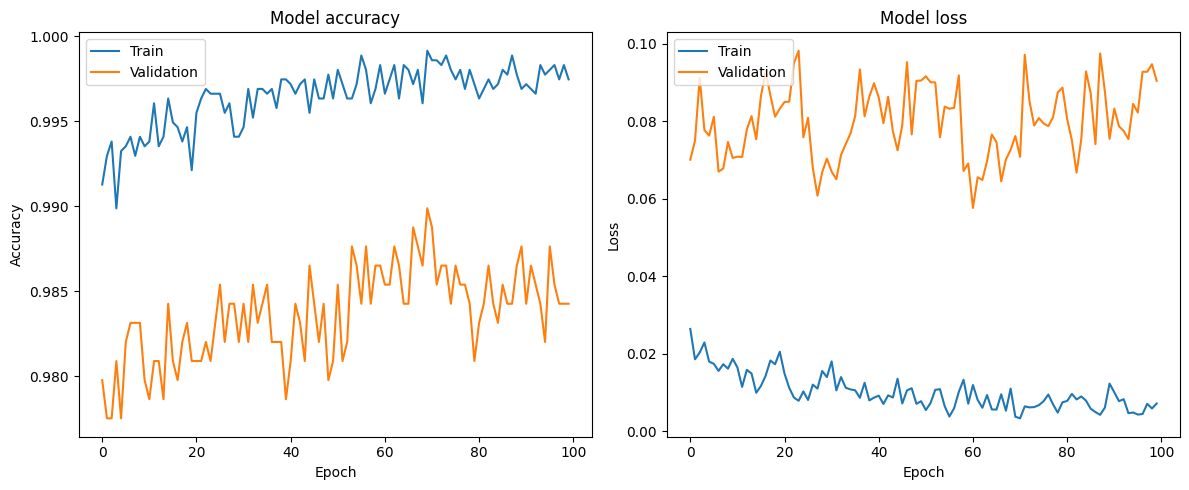

In [26]:
plot_training_history(history)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


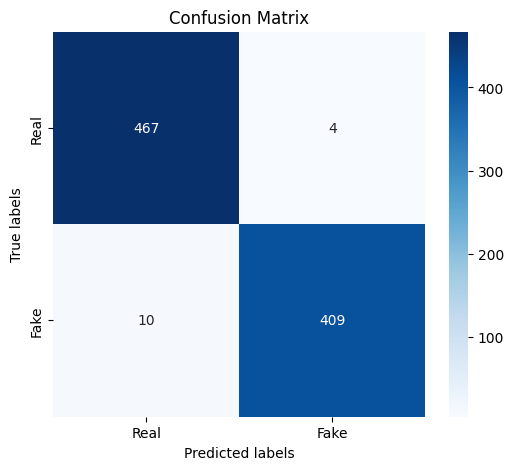

In [27]:
y_pred_raw = model.predict(X_test_reshaped)
y_pred = (y_pred_raw > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred)

In [30]:
model.save("deepfake_detection_model.keras")

In [31]:
new_model = tf.keras.models.load_model("deepfake_detection_model.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [33]:
import joblib
import os

# Save the scaler object to a file
joblib.dump(scaler, 'scaler.pkl')

# Verify if the file was created successfully
if os.path.exists('scaler.pkl'):
    print("Scaler successfully saved to 'scaler.pkl'.")
else:
    print("Failed to save the scaler.")

Scaler successfully saved to 'scaler.pkl'.


In [36]:
!pip install streamlit

In [38]:
%%writefile app.py
import streamlit as st
import librosa
import numpy as np
import tensorflow as tf
import joblib
import os

# Load the saved model and scaler
@st.cache_resource
def load_assets():
    model = tf.keras.models.load_model('deepfake_detection_model.keras')
    scaler = joblib.load('scaler.pkl')
    return model, scaler

model, scaler = load_assets()

def extract_features(file):
    # Load audio
    audio, sr = librosa.load(file, sr=16000)
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    # Mean across time
    return np.mean(mfccs.T, axis=0)

# Streamlit UI
st.title("Audio Deepfake Detector")
st.write("Upload an audio file (.wav or .mp3) to check if it is Real or Fake.")

uploaded_file = st.file_uploader("Choose an audio file", type=['wav', 'mp3'])

if uploaded_file is not None:
    st.audio(uploaded_file, format='audio/wav')

    if st.button("Analyze Audio"):
        with st.spinner('Extracting features and predicting...'):
            # 1. Feature Extraction
            features = extract_features(uploaded_file)

            # 2. Scaling
            features_scaled = scaler.transform(features.reshape(1, -1))

            # 3. Reshape for LSTM (samples, timesteps, features)
            features_reshaped = features_scaled.reshape(1, 1, 40)

            # 4. Prediction
            prediction = model.predict(features_reshaped)[0][0]
            result = "Fake" if prediction > 0.5 else "Real"
            confidence = prediction if prediction > 0.5 else 1 - prediction

            # Display results
            if result == "Fake":
                st.error(f"Result: {result} (Confidence: {confidence:.2%})")
            else:
                st.success(f"Result: {result} (Confidence: {confidence:.2%})")

Overwriting app.py
